In [1]:
import matplotlib.pylab as plt
import math
import numpy as np
import networkx as nx
import snap
import scipy.special
from tqdm.auto import tqdm
from scipy import sparse
from scipy import spatial, sparse
from scipy.stats import norm

from NetworkIVSim import *

## Leung's Sparse Graph DGP

Network data in my simulations is generated using the methodology from Leung (*Restat* [2020](https://direct.mit.edu/rest/article-abstract/102/2/368/96745/Treatment-and-Spillover-Effects-Under-Network?redirectedFrom=fulltext)). He and co-authors in other papers develop asymptotic theory for networks that are **sparse**. Sparsity there is an important requirment to make network formation models well defined and obtain convergence of various network statistics in the standard sense. Sparsity is typically defined so that 
$$\text{deg}^{G_N}_i < C $$
where $\text{deg}^{G_N}_i$ is the number of friends that $i$ has in the network G of size $N$. Here is an example of such network:

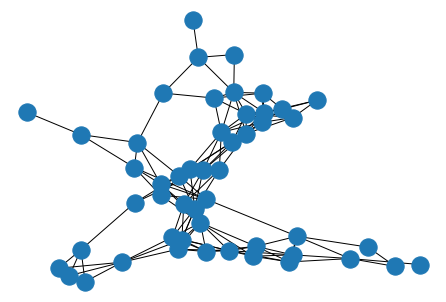

In [402]:
G = leung_sparse_network(n = 50)
nx.draw(G)

# Network Instruments

Assume a standard NPIV setup, with $(Y, X, W)$ observed as data. Agents are connected to each other in a network $G$, which is also observed. In contrast to the standard NPIV setting, we assume that peer shifters $\{z_j| j \in G_i\}$ can serve as exogenous shifters of $x_i$. Here is an example DGP:

\begin{align*}
\begin{split}
&y_i = \sin{(6x_i)}\log{(x_i)} + u_i\\
&x_i = \Phi([z_i +\gamma \overline{G}_iz + \rho\nu_i]\otimes\nu_i) \\
&w_i = \Phi(z_i) \\
&w^{netw}_i = \Phi(\overline{G}_iz)
\end{split}
\end{align*}
where $\Phi$ is the $N(0,1)$ CDF function and $[z_i +\gamma \overline{G}_iz + \rho\nu_i]\otimes\nu_i$ is an equal weight mixture of $z_i +\gamma \overline{G}_iz + \rho\nu_i$ and $\nu_i$. Here $\gamma$ serves as a parameter that measures the power of Network IV, while $\rho$ captures the degree of ill-posedness. The network formation is independent of everything in the model and is done according to the model mentioned above.
Noise terms are distributed as follows:

\begin{align*}
\begin{split}
\begin{pmatrix} u \\ v \\ z \end{pmatrix} \sim \mathcal{N}(\boldsymbol{0}, \Sigma) \text{  where } \Sigma = \begin{pmatrix} 1 & 0.5 & 0 \\ 0.5 & 1 & 0 \\ 0 & 0 & 1\end{pmatrix}
\end{split}
\end{align*}

**We conjecture that in this setup using the network IV will improve the performance of the NPIV estimator. Moreover, the improvement will be more pronounced when $\rho$ - the degree of ill-posedness is high.**

First, we run some simple simulations for the linear model to demonstrate that omitting valid Network instruments hurts numerical properties of the estimator. Second, in the NPIV context, we demonstrate that Network IV can significantly improve the performance of the estimator when the model is severely ill-posed. In the NPIV setting, I am using polynomial basis of degree 3. However, note that with high degree of ill-posedness NPIV estimator becomes unstable

# Linear IV

In [403]:
params_dict = {
    'N': 1000,
    'beta': np.array([[1,2]]).T, # beta_2 is the coefficient of interest
    'rho': 1, # here rho measures the degree of endogeneity
    'pi': 0.5,
    'gamma':0.5
}

In [404]:

beta_iv,beta_netwiv = MC_linear_IV(params_dict, n_sim=500)

## Baseline

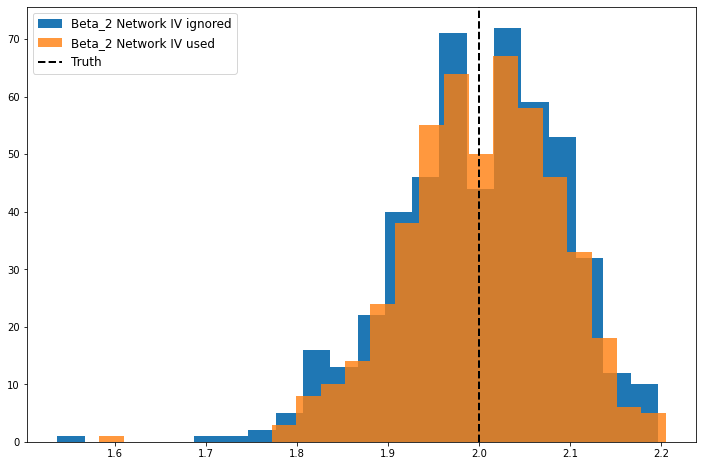

In [405]:
beta_2_iv     = [betas[1,0] for betas in beta_iv]
beta_2_netwiv = [betas[1,0] for betas in beta_netwiv]

plt.figure(figsize=(12,8))
plt.hist(beta_2_iv,bins = 'auto', label='Beta_2 Network IV ignored')
plt.hist(beta_2_netwiv, alpha=0.8, bins = 'auto', label='Beta_2 Network IV used')
plt.axvline(x=2, color = 'black', linestyle = '--', linewidth = 2, label = 'Truth')
plt.legend(loc='upper right')
plt.legend(prop={'size': 12})
plt.show()

In [406]:
l2     = np.sqrt(np.mean((np.array(beta_2_iv) - 2)**2))
l2_netw = np.sqrt(np.mean((np.array(beta_2_netwiv) - 2)**2))
print(f'L2 loss 2SLSIV : {l2}')
print(f'L2 loss 2SLS with NetwIV: {l2_netw}')

std_iv = np.std(beta_2_iv)
std_netwiv = np.std(beta_2_netwiv)
print(f'Std 2SLSIV: {std_iv}')
print(f'Std with NetwIV: {std_netwiv}')




L2 loss 2SLSIV : 0.09127786048779846
L2 loss 2SLS with NetwIV: 0.08232123802429006
Std 2SLSIV: 0.09127785733969714
Std with NetwIV: 0.08228620211598794


## Endogeneity More Severe

In [407]:
params_dict = {
    'N': 1000,
    'beta': np.array([[1,2]]).T,
    'rho': 2,
    'pi': 0.5,
    'gamma':0.5
}

In [408]:
beta_iv_severe, beta_netwiv_severe = MC_linear_IV(params_dict, n_sim=500, seed = 4000)

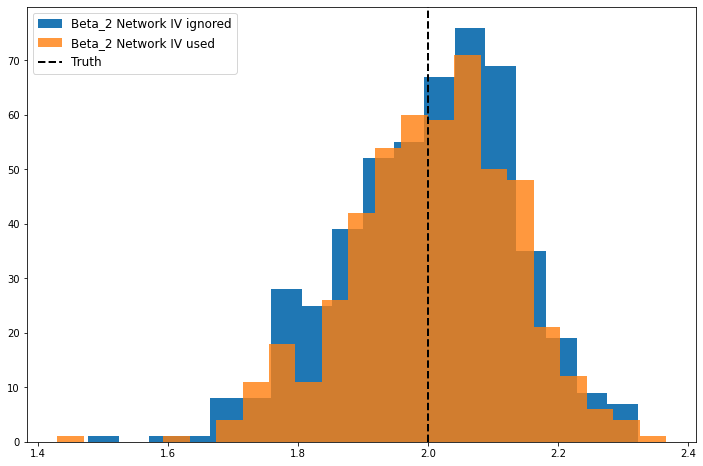

In [411]:
beta_2_iv     = [betas[1,0] for betas in beta_iv_severe]
beta_2_netwiv = [betas[1,0] for betas in beta_netwiv_severe]

plt.figure(figsize=(12,8))
plt.hist(beta_2_iv,bins = 'auto', label='Beta_2 Network IV ignored')
plt.hist(beta_2_netwiv, alpha=0.8, bins = 'auto', label='Beta_2 Network IV used')
plt.axvline(x=2, color = 'black', linestyle = '--', linewidth = 2, label = 'Truth')
plt.legend(loc='upper right')
plt.legend(prop={'size': 12})
plt.show()

In [412]:
l2     = np.sqrt(np.mean((np.array(beta_2_iv) - 2)**2))
l2_netw = np.sqrt(np.mean((np.array(beta_2_netwiv) - 2)**2))
print(f'L2 loss 2SLSIV : {l2}')
print(f'L2 loss 2SLS with NetwIV: {l2_netw}')

std_iv = np.std(beta_2_iv)
std_netwiv = np.std(beta_2_netwiv)
print(f'Std 2SLSIV: {std_iv}')
print(f'Std with NetwIV: {std_netwiv}')





L2 loss 2SLSIV : 0.13377356351118933
L2 loss 2SLS with NetwIV: 0.1269513184320612
Std 2SLSIV: 0.13374210315620516
Std with NetwIV: 0.1267518676084567


# NPIV

## Baseline

In [32]:
params_dict = {}
params_dict['N'] = 1000
params_dict['Sigma'] = np.array([[1, 0.5, 0], 
          [0.5, 1, 0],
          [0, 0, 1]])

params_dict['rho'] = 0.5
params_dict['gamma'] = 0.5
params_dict['n_b_terms'] = 3

beta,beta_netw = MC_NPIV_est(params_dict, seed=1200)

In [33]:
l2, l2_netw = MC_NPIV_loss(params_dict, beta, beta_netw)

In [34]:
print(f'L2 loss NPIV : {l2}')
print(f'L2 loss NetwNPIV: {l2_netw}')


L2 loss NPIV : 0.11882418272173945
L2 loss NetwNPIV: 0.09599342139768167


In [35]:
h_true, h_hat, h_hat_netw = MC_NPIV_plot(params_dict, beta, beta_netw)

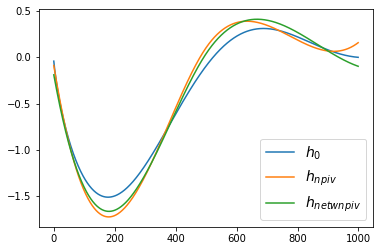

In [36]:
plt.plot(h_true, label = '$h_0$')
plt.plot(h_hat, label = '$h_{npiv}$')
plt.plot(h_hat_netw, label = '$h_{netwnpiv}$')
plt.legend(fontsize = 14)
plt.show()

## Severe Ill-posedness

In [42]:
params_dict = {}
params_dict['N'] = 1000
params_dict['Sigma'] = np.array([[1, 0.5, 0], 
          [0.5, 1, 0],
          [0, 0, 1]])

params_dict['rho'] = 1
params_dict['gamma'] = 0.5
params_dict['n_b_terms'] = 3

beta,beta_netw = MC_NPIV_est(params_dict, seed=1500)

In [43]:
l2, l2_netw = MC_NPIV_loss(params_dict, beta, beta_netw)

In [44]:
print(f'L2 loss NPIV : {l2}')
print(f'L2 loss NetwNPIV: {l2_netw}')



L2 loss NPIV : 1.3564237529248067
L2 loss NetwNPIV: 0.5266377249832647


In [45]:
h_true, h_hat, h_hat_netw = MC_NPIV_plot(params_dict, beta, beta_netw)

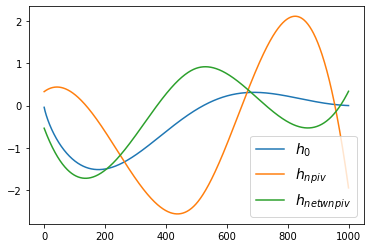

In [46]:
plt.plot(h_true, label = '$h_0$')
plt.plot(h_hat, label = '$h_{npiv}$')
plt.plot(h_hat_netw, label = '$h_{netwnpiv}$')
plt.legend(fontsize = 14)
plt.show()